Import relevant libraries and classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import time
from ipywidgets import interact
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML, display

## Variables

Here's where all of your config happens. Change these variables to change how the animation looks and how fast it goes.

This is a list of all of the different places where data can be accessed from. Change the number in CURRENT_SOURCE to point to a different location.

In [2]:
NSIDC_0051_NORTH_URL_FORMAT = "/projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/north/daily/{}/nt_{}_f17_v1.1_n.bin"
NSIDC_0051_SOUTH_URL_FORMAT = "/projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/south/daily/{}/nt_{}_f17_v1.1_s.bin"
NSIDC_0051_NORTH_STAGING_URL_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0051_ gsfc_nasateam_seaice/final-gsfc/"
                                       "north/daily/{}/nt_{}_f17_v1.1_n.bin")
NSIDC_0051_SOUTH_STAGING_URL_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/"
                                       "south/daily/{}/nt_{}_f17_v1.1_s.bin")

SOURCES = [NSIDC_0051_NORTH_URL_FORMAT, NSIDC_0051_SOUTH_URL_FORMAT, NSIDC_0051_NORTH_STAGING_URL_FORMAT, NSIDC_0051_SOUTH_STAGING_URL_FORMAT]

CURRENT_SOURCE = SOURCES[0]

This is the start date and end date for the animation. The script will skip over files that don't exist.

In [3]:
TIMEFRAME = [datetime(2015, 2, 1), datetime(2015, 12, 31)]

This is the framerate for the animation. `interval` refers to the time between frames, in MS. If simpler set using the `fps` variable.

In [4]:
INTERVAL = 100
FPS = 1000/INTERVAL

Use this parameter to change the coloring of the map generated. `"Blues"` generates a bluescale on white background, `"jet"` is yellow/green on a red background, `"terrain_r"` is blue/green on white background, and `"winter"` is green on blue background. The other ones you might have to try for yourself.

In [ ]:
COLORMAPS = ["Blues", "jet", "terrain_r", "winter", "gist_ncar", "rainbow", "magma", "prism", "spectral", "cool", "gist_earth_r"]
CURRENT_COLORMAP = COLORMAPS[1]

Finally, use this variable to toggle log messages. (True/False, case sensitive)

In [5]:
VERBOSE = True

These are some constants and helper methods.

In [6]:
plt.rcParams['animation.writer']= 'avconv'

#blatantly copied from http://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
def daterange(timeframe):
    for n in range(int ((timeframe[1] - timeframe[0]).days)):
        yield timeframe[0] + timedelta(n)        

def form_smashed_date(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

Rendering data for 2015-02-01 00:00:00
Rendering data for 2015-02-01 00:00:00
Rendering data for 2015-02-02 00:00:00
Rendering data for 2015-02-03 00:00:00
Rendering data for 2015-02-04 00:00:00
Rendering data for 2015-02-05 00:00:00
Rendering data for 2015-02-06 00:00:00
Rendering data for 2015-02-07 00:00:00
Rendering data for 2015-02-08 00:00:00
Rendering data for 2015-02-09 00:00:00
Rendering data for 2015-02-10 00:00:00
Rendering data for 2015-02-11 00:00:00
Rendering data for 2015-02-12 00:00:00
Rendering data for 2015-02-13 00:00:00
Rendering data for 2015-02-14 00:00:00
Rendering data for 2015-02-15 00:00:00
Rendering data for 2015-02-16 00:00:00
Rendering data for 2015-02-17 00:00:00
Rendering data for 2015-02-18 00:00:00
Rendering data for 2015-02-19 00:00:00
Rendering data for 2015-02-20 00:00:00
Rendering data for 2015-02-21 00:00:00
Rendering data for 2015-02-22 00:00:00
Rendering data for 2015-02-23 00:00:00
Rendering data for 2015-02-24 00:00:00
Rendering data for 2015-0

Rendering data for 2015-02-01 00:00:00


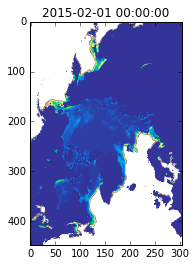

In [9]:
%matplotlib inline

index = 0
rng = []
last_dataset = None
for date in daterange(TIMEFRAME):
    rng.append(date)

def setup():
    plt.figure()

def render(index):
    datetime = get_current_datetime(index)
    year = datetime.year
    uri = CURRENT_SOURCE.format(year, form_smashed_date(datetime))
    if VERBOSE:
        print("Rendering data for " + str(datetime))
    try:
        with open(uri, 'rb') as fp:
            header = fp.read(300)
            nsidc_0051_data = np.fromfile(fp, dtype=np.uint8).reshape(get_current_dataset_shape())
        plt.title(str(datetime))
        im = plt.imshow(nsidc_0051_data, cmap=CURRENT_COLORMAP, animated=True)
    except FileNotFoundError as e:
        print("No file called " + uri)
        plt.title("DATA MISSING FOR " + str(start_date))
        im = plt.imshow(last_dataset, animated=True)
    else:
        index += 1
        return [im]

def get_current_datetime(index):
    return rng[index]

def get_current_dataset_shape():
    if CURRENT_SOURCE == NSIDC_0051_NORTH_URL_FORMAT or CURRENT_SOURCE == NSIDC_0051_NORTH_STAGING_URL_FORMAT:
        return (448, 304)
    elif CURRENT_SOURCE == NSIDC_0051_SOUTH_URL_FORMAT or CURRENT_SOURCE == NSIDC_0051_SOUTH_STAGING_URL_FORMAT:
        return (332, 316)
    else:
        print("SOMETHING'S WRONG!")
        return (720, 720)

fig = plt.figure()
anim = animation.FuncAnimation(fig, render, frames=len(rng), fargs=index, interval=INTERVAL, repeat=True)
HTML(anim.to_html5_video())